In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

N_Cls = 10
inDir = '/home/rob/Udacity/capstone/data'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 80
smooth = 1e-12

Using TensorFlow backend.


In [2]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

    np.save('data/x_trn_%d' % N_Cls, x)
    np.save('data/y_trn_%d' % N_Cls, y)


def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


def make_val():
    print "let's pick some samples for validation"
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save('data/x_tmp_%d' % N_Cls, x)
    np.save('data/y_tmp_%d' % N_Cls, y)


def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


def calc_jacc(model):
    img = np.load('data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print "start train net"
    x_val, y_val = np.load('data/x_tmp_%d.npy' % N_Cls), np.load('data/y_tmp_%d.npy' % N_Cls)
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7878')
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights('weights/unet_10_jk%.4f' % score)

    return model


def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id


def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv('subm/2.csv', index=False)


def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0
let's pick some samples for validation
(1358, 8, 80, 80) (1358, 10, 80, 80) 1.0 -1.0 1.0 0.0
start train net
(4639, 8, 80, 80) (4639, 10, 80, 80) 1.0 -1.0 1.0 0.0
Train on 4639 samples

Self-intersection at or near point 295.52499999999998 234.69374999999999


    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
0


Self-intersection at or near point 250.40298507462686 265.13432835820896
Self-intersection at or near point 157.00544959128067 158.83378746594005
Self-intersection at or near point 65.018181818181816 317.58181818181816
Self-intersection at or near point 405.25 236.4375
Self-intersection at or near point 321.90718562874252 403.41317365269464
Self-intersection at or near point 398.52272727272725 460.14772727272725
Self-intersection at or near point 321.60256410256409 63.301282051282051
Self-intersection at or near point 268.07142857142856 380.07142857142856
Self-intersection at or near point 478.68656716417911 65.955223880597018
Self-intersection at or near point 477.252427184466 161.76699029126215
Ring Self-intersection at or near point 324 185
Self-intersection at or near point 158.25 99.75
Self-intersection at or near point 316.42180094786733 226.12322274881515
Self-intersection at or near point 350.86725663716817 245.30973451327435
Self-intersection at or near point 77.85714285714286

100


Self-intersection at or near point 394.38028169014086 202.64788732394365
Ring Self-intersection at or near point 453 67
Self-intersection at or near point 42.150684931506852 100.48630136986301
Self-intersection at or near point 396.09205020920501 79.043235704323564
Self-intersection at or near point 316.42382271468142 155.78393351800554
Self-intersection at or near point 448.67901234567898 401.79012345679013
Self-intersection at or near point 279.70873786407765 2.3300970873786406
Self-intersection at or near point 478.09512761020881 77.953596287703022
Self-intersection at or near point 330.76170212765959 7.3063829787234038
Self-intersection at or near point 339.22935779816515 122.09174311926606
Self-intersection at or near point 317 238.5
Self-intersection at or near point 321.13636363636363 319.13636363636363
Self-intersection at or near point 477.43224299065423 205.14252336448598
Ring Self-intersection at or near point 252 400


200


Self-intersection at or near point 170.85714285714286 105.28571428571429
Self-intersection at or near point 349.35532994923858 102.01015228426395
Self-intersection at or near point 477.96638655462186 96.016806722689068
Self-intersection at or near point 357.01463414634145 77.063414634146341
Self-intersection at or near point 47.576547231270361 248.93159609120522
Self-intersection at or near point 478.71698113207549 65.245283018867923
Self-intersection at or near point 398.171974522293 402.75159235668792
Self-intersection at or near point 81.213049267643143 443.23302263648469
Self-intersection at or near point 193.30769230769232 347.3609467455621
Self-intersection at or near point 275.75590551181102 157.9291338582677
Self-intersection at or near point 192 0
Self-intersection at or near point 478.06400000000002 238.10400000000001
Self-intersection at or near point 339.61111111111109 397.08333333333331
Self-intersection at or near point 198.29303442754204 77.365092073658928
Self-intersect

300


Ring Self-intersection at or near point 77 399
Self-intersection at or near point 399 236.59459459459458
Self-intersection at or near point 157.13886536833192 315.81964436917866
Self-intersection at or near point 445.83008356545963 75.791086350974936
Self-intersection at or near point 460.74468085106383 418.40425531914894
Self-intersection at or near point 13 400
Self-intersection at or near point 0.51674641148325362 237.79425837320574
Self-intersection at or near point 476.32824427480915 372.75572519083971
Self-intersection at or near point 442.38344226579522 161.33551198257081
Self-intersection at or near point 476.4375 286.1875
Self-intersection at or near point 352.96850393700788 333.77952755905511
Self-intersection at or near point 319 398.44444444444446
Self-intersection at or near point 396.9455252918288 416.95719844357978
Self-intersection at or near point 16.913793103448278 320.37356321839081
Self-intersection at or near point 396.68316831683171 170.05940594059405


400


Self-intersection at or near point 235.66666666666666 409.66666666666669
Self-intersection at or near point 458.078125 465.6015625
Self-intersection at or near point 396.01234567901236 159
Self-intersection at or near point 415.86666666666667 0.46666666666666667
Self-intersection at or near point 401 162.04444444444445
Self-intersection at or near point 419.92592592592592 242.08641975308643
Self-intersection at or near point 238.09807692307692 391.74230769230769
Self-intersection at or near point 477.796875 320.5078125
Self-intersection at or near point 407.2809364548495 21.979933110367892
Self-intersection at or near point 290.17857142857144 75.035714285714292
Self-intersection at or near point 401.20172910662825 191.77809798270894
Self-intersection at or near point 227.08609271523179 138.95364238410596
Self-intersection at or near point 400.93167701863354 239.17184265010351


500


Self-intersection at or near point 478.01123595505618 241.7865168539326
Self-intersection at or near point 164.80000000000001 418.80000000000001
Self-intersection at or near point 237.76373626373626 187.11263736263737
Self-intersection at or near point 122.30985915492958 5.830985915492958
Self-intersection at or near point 319.07692307692309 199.87912087912088
Self-intersection at or near point 96 305.625
Self-intersection at or near point 190.25 202.875
Self-intersection at or near point 327.33333333333331 455.66666666666669
Self-intersection at or near point 478.41754385964913 311.63157894736844
Self-intersection at or near point 477.91150442477874 219.01769911504425
Self-intersection at or near point 5.0598802395209574 202.94610778443115
Self-intersection at or near point 441.87364620938627 245.44404332129963
Self-intersection at or near point 369.95294117647057 70.882352941176464
Self-intersection at or near point 128.17391304347825 127.65217391304348
Self-intersection at or near p

600


Self-intersection at or near point 416.23076923076923 21.846153846153847
Self-intersection at or near point 349.10596026490066 82.092715231788077
Self-intersection at or near point 380.29199999999997 112.122
Self-intersection at or near point 304.70886075949369 319.05063291139243
Ring Self-intersection at or near point 157 479
Ring Self-intersection at or near point 479 274
Self-intersection at or near point 449.11009174311926 110.37531276063386
Self-intersection at or near point 43.032967032967036 206.8131868131868
Self-intersection at or near point 305 0
Self-intersection at or near point 343 75.421052631578945
Self-intersection at or near point 357.94902548725639 401.61169415292352
Self-intersection at or near point 235.5 401.75


700


Self-intersection at or near point 356.44628099173553 156.80991735537191
Ring Self-intersection at or near point 0 457
Self-intersection at or near point 134.18367346938774 175.10204081632654
Self-intersection at or near point 37.669291338582674 138.38582677165354
Self-intersection at or near point 360.21875 78.21875
Self-intersection at or near point 332.52892561983469 73.330578512396698
Self-intersection at or near point 250.06451612903226 396.29032258064518


800


Self-intersection at or near point 155.98245614035088 351.84210526315792
Self-intersection at or near point 476.11111111111109 156.55555555555554
Ring Self-intersection at or near point 76 44
Ring Self-intersection at or near point 20 68
Self-intersection at or near point 238.12701421800949 316.52322274881516
Self-intersection at or near point 122 160
Self-intersection at or near point 420.98058252427182 33.145631067961162
Self-intersection at or near point 402.53846153846155 118.15384615384616
Self-intersection at or near point 199.43312101910828 194.14012738853503
Self-intersection at or near point 416 27.892857142857142


900


Self-intersection at or near point 276.00567644276254 478.86944181646169
Self-intersection at or near point 398.75 108.5
Self-intersection at or near point 235.09929078014184 397.33687943262413
Self-intersection at or near point 477.37007874015745 421.59055118110234
Self-intersection at or near point 158.55172413793105 115.86206896551724
Self-intersection at or near point 374.01886792452831 6.4528301886792452
Self-intersection at or near point 104.28571428571429 50.857142857142854
Self-intersection at or near point 429 239
Ring Self-intersection at or near point 320 142
Self-intersection at or near point 432.84615384615387 395.85897435897436
Self-intersection at or near point 87.239999999999995 75.879999999999995
Self-intersection at or near point 404.06930693069307 155.96039603960395
Self-intersection at or near point 399 316
Self-intersection at or near point 473.04724409448818 384.89763779527561


1000


Self-intersection at or near point 406.31343283582089 9.4029850746268657
Self-intersection at or near point 71.097560975609753 401.60975609756099
Ring Self-intersection at or near point 320 320
Self-intersection at or near point 165.37681159420291 104.80193236714976
Self-intersection at or near point 101.89655172413794 214.27586206896552
Self-intersection at or near point 476.41176470588238 158.47058823529412
Self-intersection at or near point 36.704663212435236 5.7512953367875648
Self-intersection at or near point 94.43795620437956 298.35766423357666
Self-intersection at or near point 157 249.90909090909091
Self-intersection at or near point 240.37974683544303 108.77215189873418
Self-intersection at or near point 302.31034482758622 35.551724137931032
Self-intersection at or near point 417.80000000000001 299.80000000000001
Self-intersection at or near point 334.63999999999999 94.680000000000007
Self-intersection at or near point 51.68292682926829 346.14634146341461
Self-intersection at

1100


Self-intersection at or near point 376 51.782608695652172
Ring Self-intersection at or near point 71 99
Self-intersection at or near point 24.160458452722064 236.55873925501433


1200


Self-intersection at or near point 135.16666666666666 183.91666666666666
Self-intersection at or near point 244.52941176470588 320.218487394958
Self-intersection at or near point 159.97794117647058 358.86029411764707
Self-intersection at or near point 3.25 213.75
Self-intersection at or near point 469 51.666666666666664
Self-intersection at or near point 351.93638676844785 43.770992366412216
Self-intersection at or near point 25.92258064516129 241.1032258064516


1300


Self-intersection at or near point 476.32432432432432 107.70270270270271
Self-intersection at or near point 401.7507163323782 322.77077363896848
Self-intersection at or near point 362.75147928994085 477.17159763313612
Self-intersection at or near point 160.69642857142858 215.23214285714286
Self-intersection at or near point 12.614457831325302 236.16867469879517
Self-intersection at or near point 159.05244755244755 463.37412587412587
Self-intersection at or near point 476.44736842105266 135.35526315789474
Ring Self-intersection at or near point 397 350
Self-intersection at or near point 255.79166666666666 304.5625
Self-intersection at or near point 424.46153846153845 291.38461538461536


1400


Self-intersection at or near point 475.7227722772277 26.207920792079207
Self-intersection at or near point 476.0919742237844 79.058582308142945
Self-intersection at or near point 475.87356321839081 468.73563218390802
Self-intersection at or near point 234.73786407766991 26.611650485436893
Self-intersection at or near point 184.91891891891891 54.804054054054056
Self-intersection at or near point 478.81609195402297 471.73563218390802
Ring Self-intersection at or near point 441 240
Self-intersection at or near point 319.36496350364962 197.69343065693431
Self-intersection at or near point 395.74698795180723 234.42168674698794


1500


Self-intersection at or near point 277.83257918552039 156.38009049773757
Self-intersection at or near point 258.92052980132451 161.18543046357615
Self-intersection at or near point 420.31979695431471 58.928934010152282
Self-intersection at or near point 152.8095238095238 116.08465608465609
Self-intersection at or near point 468.33333333333331 463
Self-intersection at or near point 75 345
Self-intersection at or near point 220.0952380952381 123.42857142857143
Self-intersection at or near point 479 97
Self-intersection at or near point 398.68055555555554 206.95833333333334
Self-intersection at or near point 331.47761194029852 443.56716417910445
Self-intersection at or near point 2.4596273291925463 425.13043478260869


1600


Self-intersection at or near point 219.63225806451612 43.703225806451613
Self-intersection at or near point 394.81176470588235 291.2823529411765
Self-intersection at or near point 145.77500000000001 175.17500000000001
Self-intersection at or near point 415.0935251798561 208.79856115107913
Self-intersection at or near point 468.03793103448277 274.97241379310344
Self-intersection at or near point 440.05405405405406 435.29729729729729
Self-intersection at or near point 448.62886597938143 79.041237113402062
Self-intersection at or near point 155.34328358208955 44.07462686567164
Self-intersection at or near point 156.48407643312103 345.9299363057325


1700


Self-intersection at or near point 474.10344827586209 256.20689655172413
Ring Self-intersection at or near point 160 62
Self-intersection at or near point 315.31818181818181 206.68181818181819
Self-intersection at or near point 327.52812499999999 147.75624999999999
Self-intersection at or near point 126.46428571428571 57.428571428571431
Self-intersection at or near point 433.33333333333331 478.33333333333331
Self-intersection at or near point 438.62745098039215 388.96078431372547
Self-intersection at or near point 334.4727272727273 83.506493506493513
Self-intersection at or near point 471.83471074380168 238.80165289256198
Self-intersection at or near point 474.89219330855019 216.20817843866172
Self-intersection at or near point 398.60000000000002 266.60000000000002
Self-intersection at or near point 312 160


1800


Self-intersection at or near point 402.72608695652173 228.31304347826088
Self-intersection at or near point 477.6431718061674 197.63436123348018
Self-intersection at or near point 399.91666666666669 418
Self-intersection at or near point 453.072 110.28
Self-intersection at or near point 366 233.63157894736841
Self-intersection at or near point 399.94444444444446 207.13888888888889
Self-intersection at or near point 78.104651162790702 168.26744186046511
Self-intersection at or near point 291.29126213592235 343.73786407766988
Self-intersection at or near point 1.0997375328083989 403.04199475065616
Self-intersection at or near point 295 476
Self-intersection at or near point 160.9375 352.375
Self-intersection at or near point 460.07042253521126 31.08450704225352


1900


Self-intersection at or near point 220.48571428571429 307.60000000000002
Self-intersection at or near point 84.442307692307693 402.73076923076923
Self-intersection at or near point 328.34246575342468 241.20547945205479
Self-intersection at or near point 372.9387755102041 143.59183673469389
Self-intersection at or near point 317.00393700787401 238.92322834645668
Self-intersection at or near point 190.09090909090909 157.45454545454547
Self-intersection at or near point 316.9531914893617 57.748936170212765
Self-intersection at or near point 348.28044692737433 394.03016759776534
Self-intersection at or near point 228.69230769230768 321.61538461538464
Self-intersection at or near point 353.64476021314385 401.82060390763763


2000


Self-intersection at or near point 314.82758620689657 426
Self-intersection at or near point 299.46768060836501 81.224334600760457
Self-intersection at or near point 355.83757961783442 258.75159235668792
Ring Self-intersection at or near point 79 239
Self-intersection at or near point 77 320
Self-intersection at or near point 12.049792531120332 400.49792531120335
Self-intersection at or near point 322.22222222222223 188.66666666666666
Self-intersection at or near point 397 0.066666666666666652
Self-intersection at or near point 371.42953020134229 241.34228187919464
Self-intersection at or near point 352.39999999999998 475.60000000000002
Self-intersection at or near point 411.96309963099628 318.66174661746618
Self-intersection at or near point 236.68595041322314 262.11570247933884
Self-intersection at or near point 229.51764705882354 412.74117647058824
Self-intersection at or near point 399.79658605974396 219.04978662873398
Self-intersection at or near point 397 305
Self-intersection at

2100


Self-intersection at or near point 435.15652173913043 351.80869565217392
Self-intersection at or near point 418.21739130434781 77.826086956521735
Self-intersection at or near point 395.41678939617083 221.09278350515464
Self-intersection at or near point 347.13643178410797 402.18590704647676
Self-intersection at or near point 415.06285714285713 0.50285714285714289
Self-intersection at or near point 78.921933085501863 470.98884758364312
Self-intersection at or near point 89.129870129870127 113.44155844155844
Self-intersection at or near point 186.05847953216374 43.590643274853804
Self-intersection at or near point 320.22857142857146 225.08571428571429
Self-intersection at or near point 464.7511961722488 316.07655502392345


2200


Self-intersection at or near point 156.81818181818181 247
Self-intersection at or near point 457.82978723404256 218.95744680851064
Self-intersection at or near point 396.2474226804124 399.91752577319585
Self-intersection at or near point 396 438.66666666666669
Self-intersection at or near point 110.04761904761905 398
Self-intersection at or near point 182.41463414634146 238.04878048780489
Self-intersection at or near point 462.56573705179284 7.0358565737051793
Ring Self-intersection at or near point 139 112
Self-intersection at or near point 479 112
Self-intersection at or near point 386.23943661971833 415.01408450704224
Self-intersection at or near point 185.82456140350877 241.35087719298247


2300


Self-intersection at or near point 441.7829457364341 230.09302325581396
Self-intersection at or near point 400.60068259385667 248.50853242320818
Self-intersection at or near point 477.56923076923078 458.3692307692308
Self-intersection at or near point 183.01599999999999 286.37599999999998
Self-intersection at or near point 321.70754716981133 344.05660377358492
Ring Self-intersection at or near point 398 438
Self-intersection at or near point 237.58415841584159 27.214521452145213
Self-intersection at or near point 478.36231884057969 398.94202898550725
Self-intersection at or near point 392.44444444444446 221.44444444444446


2400


Self-intersection at or near point 90.352941176470594 236.58823529411765
Self-intersection at or near point 321 53.5
Ring Self-intersection at or near point 320 345
Self-intersection at or near point 122.931640625 3.1171875
Self-intersection at or near point 299.2093023255814 80.465116279069761
Self-intersection at or near point 272.5 328.25
Self-intersection at or near point 401.13291139240505 258.95569620253167
Self-intersection at or near point 341.90909090909093 191.45454545454547
Self-intersection at or near point 173 264.30000000000001
Self-intersection at or near point 60.294642857142854 191.9375
Self-intersection at or near point 398.11711711711712 392.2072072072072
Self-intersection at or near point 356.66878980891721 67.929936305732483


2500


Self-intersection at or near point 235.98765432098764 419.50617283950618
Self-intersection at or near point 78.764705882352942 352.41176470588238
Self-intersection at or near point 408.38356164383561 175.46575342465752
Self-intersection at or near point 108.68000000000001 452.36000000000001
Self-intersection at or near point 403.34545454545457 17.072727272727274
Ring Self-intersection at or near point 157 479
Self-intersection at or near point 150.12280701754386 114.59649122807018
Self-intersection at or near point 1.2565130260521042 302.58316633266531
Self-intersection at or near point 310.55555555555554 27.148148148148149
Self-intersection at or near point 283.68656716417911 191.86567164179104
Self-intersection at or near point 371 356.14285714285717


2600


Self-intersection at or near point 348.9568345323741 399.35251798561148
Self-intersection at or near point 416.29729729729729 478.18018018018017
Self-intersection at or near point 392.15909090909093 80.38636363636364
Self-intersection at or near point 283.54736842105262 12.631578947368421
Self-intersection at or near point 258.78947368421052 179.57894736842104
Self-intersection at or near point 377.93288590604027 82.147651006711413
Self-intersection at or near point 466.60693641618496 286.03468208092488
Self-intersection at or near point 278.28169014084506 212.61032863849766


2700


Self-intersection at or near point 446.89285714285717 354.07142857142856
Self-intersection at or near point 10.714285714285715 251.14285714285714
Self-intersection at or near point 320.48000000000002 100.88
Self-intersection at or near point 246 298.54545454545456
Ring Self-intersection at or near point 330 0
Self-intersection at or near point 321.59541984732823 240.61832061068702
Self-intersection at or near point 317 477.44444444444446
Self-intersection at or near point 478.46478873239437 280.18309859154931
Self-intersection at or near point 302.69565217391306 318.38339920948619


2800


Ring Self-intersection at or near point 384 67
Self-intersection at or near point 27 359
Self-intersection at or near point 342.27450980392155 238.0392156862745
Ring Self-intersection at or near point 158 469
Self-intersection at or near point 313.22727272727275 265.19230769230768
Self-intersection at or near point 256.27705627705626 448.10389610389609
Self-intersection at or near point 460.35849056603774 157.96226415094338
Self-intersection at or near point 40 121
Self-intersection at or near point 232.47511312217193 1.3393665158371042


2900


Self-intersection at or near point 460.57142857142856 329.42857142857144
Self-intersection at or near point 300.57046979865771 355.69798657718121
Self-intersection at or near point 183.04545454545453 460.27272727272725
Self-intersection at or near point 455.31428571428569 139.48571428571429
Self-intersection at or near point 161.42996742671011 79.788273615635177
Self-intersection at or near point 239 242
Self-intersection at or near point 429.14741035856576 242.05179282868525
Self-intersection at or near point 318.08571428571429 398.05714285714288
Self-intersection at or near point 475.05882352941177 19.431372549019606


3000


Self-intersection at or near point 317.00284090909093 398.94744318181819
Self-intersection at or near point 382.24137931034483 447.93103448275861
Self-intersection at or near point 205.79710144927537 194.75362318840581
Self-intersection at or near point 396.75 290.5
Self-intersection at or near point 463.21937321937321 32.940170940170937
Ring Self-intersection at or near point 356 32
Self-intersection at or near point 475 237.63636363636363
Self-intersection at or near point 475.81967213114751 118.98360655737704
Ring Self-intersection at or near point 159 64
Self-intersection at or near point 261.24539877300612 174.14110429447854
Self-intersection at or near point 94.21052631578948 82.15789473684211
Self-intersection at or near point 317.97029702970298 303.03960396039605
Ring Self-intersection at or near point 152 468


3100


Self-intersection at or near point 314.29559748427675 233.28301886792454
Self-intersection at or near point 395.12292358803984 338.54485049833886
Self-intersection at or near point 401.11538461538464 285.38461538461536
Self-intersection at or near point 403 169.80000000000001
Self-intersection at or near point 423.95824634655531 414.13569937369522
Self-intersection at or near point 478.03763900769889 402.93584260051324
Self-intersection at or near point 330.72222222222223 160


3200


Self-intersection at or near point 125.66666666666667 141
Self-intersection at or near point 367.7560975609756 466.70731707317071
Self-intersection at or near point 352.06315789473683 317.75526315789472
Self-intersection at or near point 158.75 82.5
Self-intersection at or near point 390.42857142857144 472.71428571428572


3300


Self-intersection at or near point 402.35820895522386 477.1194029850746
Ring Self-intersection at or near point 226 249
Ring Self-intersection at or near point 317 159
Self-intersection at or near point 320.14606741573033 445.43820224719099
Self-intersection at or near point 232.71090047393366 324.09478672985784
Self-intersection at or near point 135.03846153846155 82.92307692307692
Ring Self-intersection at or near point 186 131
Self-intersection at or near point 411.87878787878788 4.7272727272727275
Self-intersection at or near point 66.731034482758616 114.28275862068965
Self-intersection at or near point 465.95652173913044 20.608695652173914


3400


Self-intersection at or near point 91 449.47058823529414
Ring Self-intersection at or near point 455 349
Self-intersection at or near point 240.85987261146497 138.51592356687897
Self-intersection at or near point 334.12857142857143 112.22857142857143
Self-intersection at or near point 221.19565217391303 430.93478260869563
Self-intersection at or near point 442.70758122743683 321.07220216606498
Self-intersection at or near point 12.018292682926829 145.8719512195122
Self-intersection at or near point 185 217
Ring Self-intersection at or near point 0 255
Self-intersection at or near point 264.01351351351349 4.0675675675675675
Self-intersection at or near point 414 53
Self-intersection at or near point 173.38938053097345 440.75221238938053


3500


Self-intersection at or near point 240.11363636363637 97.772727272727266
Self-intersection at or near point 400.78947368421052 274.78947368421052
Self-intersection at or near point 474.64516129032256 382.51612903225805
Self-intersection at or near point 245.5234375 130.3359375
Self-intersection at or near point 316.79310344827587 160.12931034482759
Self-intersection at or near point 155.048 478.26799999999997
Self-intersection at or near point 467.85714285714283 211.78571428571428
Self-intersection at or near point 94.806451612903231 397.45161290322579


3600


Self-intersection at or near point 401.72727272727275 429.45454545454544
Self-intersection at or near point 273.17391304347825 164.69565217391303
Self-intersection at or near point 366.13793103448273 455.95172413793102
Self-intersection at or near point 465.45454545454544 30.030303030303031
Self-intersection at or near point 478.57110091743118 245.00229357798165
Self-intersection at or near point 396.47107438016531 259.43801652892563
Self-intersection at or near point 299.80303030303031 274.06060606060606


3700


Self-intersection at or near point 125.27692307692308 405.81538461538463
Self-intersection at or near point 238.05555555555554 318
Self-intersection at or near point 236.74285714285713 365.32857142857142
Self-intersection at or near point 399.23255813953489 468.25581395348837
Self-intersection at or near point 283.94285714285712 467.24897959183676
Self-intersection at or near point 402.6709265175719 399.01597444089458
Self-intersection at or near point 318.00980392156862 115.73529411764706
Self-intersection at or near point 475 151.25
Self-intersection at or near point 439 386
Self-intersection at or near point 17.16 125.84
Self-intersection at or near point 326.57142857142856 80
Self-intersection at or near point 471.74534161490681 100.57763975155279
Self-intersection at or near point 395 404
Self-intersection at or near point 424.41275797373356 76.707317073170728
Self-intersection at or near point 399 282


3800


Self-intersection at or near point 476.8360655737705 320
Self-intersection at or near point 317.48669201520914 372.85931558935363
Self-intersection at or near point 285.55497382198951 316.5916230366492
Self-intersection at or near point 464.74829931972789 403.26530612244898
Self-intersection at or near point 398.73913043478262 228.69565217391303
Self-intersection at or near point 377.33333333333331 15.5
Self-intersection at or near point 423.46511627906978 157.53488372093022
Self-intersection at or near point 402.28978224455614 183.24120603015075
Self-intersection at or near point 361.94999999999999 175
Self-intersection at or near point 460.7831325301205 277.20481927710841
Ring Self-intersection at or near point 175 160
Self-intersection at or near point 402.76335877862596 27.755725190839694
Self-intersection at or near point 476.59455370650528 465.72163388804842
Ring Self-intersection at or near point 454 320


3900


Self-intersection at or near point 454.62068965517244 74.310344827586206
Self-intersection at or near point 478.27884615384613 181.75
Self-intersection at or near point 458.27956989247309 446.92473118279571
Self-intersection at or near point 382.47826086956519 89.826086956521735
Self-intersection at or near point 338.40845070422534 103.2394366197183
Self-intersection at or near point 411.40969162995594 313.32599118942733
Self-intersection at or near point 460.89041095890411 421.8082191780822
Self-intersection at or near point 148 400
Self-intersection at or near point 133.00995024875621 105.09950248756219
Self-intersection at or near point 82.900090009000905 391.70747074707469
Ring Self-intersection at or near point 479 29
Self-intersection at or near point 429.5 68
Self-intersection at or near point 447.75 188.875
Self-intersection at or near point 318.06145251396646 78.07821229050279


4000


Self-intersection at or near point 454.31662269129288 82.269129287598943
Ring Self-intersection at or near point 203 177
Ring Self-intersection at or near point 159 303
Self-intersection at or near point 285.14606741573033 30.561797752808989
Self-intersection at or near point 162.98876404494382 161.20224719101122


4100


Self-intersection at or near point 458.40340909090907 230.32954545454547
Self-intersection at or near point 476.91176470588238 421.22058823529414
Ring Self-intersection at or near point 422 239
Self-intersection at or near point 367.34193548387094 80.638709677419357
Self-intersection at or near point 473.59375 402.484375
Self-intersection at or near point 73.220588235294116 240.36764705882354
Self-intersection at or near point 203.19999999999999 411.80000000000001
Self-intersection at or near point 30.296296296296298 371.40740740740739
Self-intersection at or near point 303.80597014925371 9.5522388059701484
Self-intersection at or near point 161.19512195121951 400.78048780487802
Self-intersection at or near point 441 56
Self-intersection at or near point 117.68888888888888 3.8133333333333335


4200


Self-intersection at or near point 278.10091743119267 402.54128440366975
Self-intersection at or near point 2.0356234096692112 190.46564885496184
Self-intersection at or near point 338.71248246844317 323.02945301542775
Self-intersection at or near point 21.646551724137932 77.612068965517238
Self-intersection at or near point 302.2162162162162 165.91891891891891
Self-intersection at or near point 455.42857142857144 223
Self-intersection at or near point 315.33333333333331 76.333333333333329
Self-intersection at or near point 254.45283018867926 100.33962264150944
Self-intersection at or near point 418.04268292682929 2.774390243902439
Self-intersection at or near point 246.8102189781022 430.68613138686129


    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1                           GEOMETRYCOLLECTION EMPTY
1  6120_2_4          2                           GEOMETRYCOLLECTION EMPTY
2  6120_2_4          3                           GEOMETRYCOLLECTION EMPTY
3  6120_2_4          4                           GEOMETRYCOLLECTION EMPTY
4  6120_2_4          5  MULTIPOLYGON (((0.0046332954588021 -0.00462812...


Self-intersection at or near point 182.28571428571428 457.42857142857144


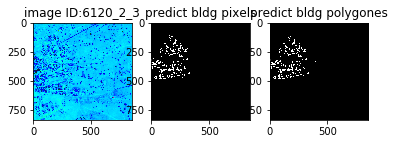

In [5]:
if __name__ == '__main__':
    stick_all_train()
    make_val()
    model = train_net()
    score, trs = calc_jacc(model)
    predict_test(model, trs)
    make_submit()

    # bonus
    check_predict()